# DLSM Architecture Translation into TensorFlow - Attempt

## Utility Imports

In [1]:
!wget -O shapedata.py https://raw.githubusercontent.com/interactive-intelligence/emergent-lang/main/shapedata.py
import shapedata
import importlib
importlib.reload(shapedata)

!wget -O analyzeutil.py https://raw.githubusercontent.com/interactive-intelligence/emergent-lang/main/analyzeutil.py
import analyzeutil
importlib.reload(analyzeutil)

--2022-04-30 04:44:08--  https://raw.githubusercontent.com/interactive-intelligence/emergent-lang/main/shapedata.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10989 (11K) [text/plain]
Saving to: ‘shapedata.py’

shapedata.py        100%[===================>]  10.73K  --.-KB/s    in 0s      

2022-04-30 04:44:08 (37.5 MB/s) - ‘shapedata.py’ saved [10989/10989]

--2022-04-30 04:44:09--  https://raw.githubusercontent.com/interactive-intelligence/emergent-lang/main/analyzeutil.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222

<module 'analyzeutil' from '/kaggle/working/analyzeutil.py'>

## Library Imports

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers as L
import tensorflow_probability as tfp
import tensorflow as tf
import tensorflow
import numpy as np
import matplotlib.pyplot as plt

## Model Definition

In [3]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices



class DLSM(tf.keras.Model):

    def __init__(self, 
                 inp_shape,           # the dimension of the image in three-element tuple form
                 seq_len=16,          # number of vectors to form a language sequence
                 vocab_size=32,       # number of unique vectors in vector quantizer
                 recurrent_units=32,  # number of gru units, also embedding dim for now
                 batch_size=32):      # number of samples per batch
        
        super().__init__()
        
        # structural params
        self.batch_size = batch_size
        self.inp_shape = inp_shape
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.recurrent_units = recurrent_units
        
        # model components
        self.vision_module = self.buildVisionModule(inp_shape)
        self.speaker = self.buildSpeaker((self.seq_len, 1))
        self.quantizer = VectorQuantizer(num_embeddings=self.vocab_size,
                                         embedding_dim=self.recurrent_units)
        self.listener = self.buildListener((self.seq_len, self.recurrent_units))
        
        # misc
        self.initial_speech = K.variable(value=np.zeros((self.batch_size, self.seq_len, 1)))
    
    def buildVisionModule(self, inp_shape):
        '''
        Vision Module - maps images to a vector with length recurrent_units.
        '''
        
        model = keras.models.Sequential(name='Vision_Module')
        model.add(L.Input(inp_shape))

        model.add(L.Conv2D(16, (2, 5), padding='same'))
        model.add(L.LeakyReLU())
        model.add(L.Conv2D(16, (2, 5), padding='same'))
        model.add(L.LeakyReLU())
        model.add(L.Conv2D(16, (2, 2), padding='same'))
        model.add(L.LeakyReLU())
        model.add(L.MaxPooling2D((2, 2)))

        model.add(L.Conv2D(16, (5, 2), padding='same'))
        model.add(L.LeakyReLU())
        model.add(L.Conv2D(16, (2, 5), padding='same'))
        model.add(L.LeakyReLU())
        model.add(L.Conv2D(16, (2, 2), padding='same'))
        model.add(L.LeakyReLU())
        model.add(L.MaxPooling2D((2, 2)))

        model.add(L.Flatten())
#         model.add(L.Dense(self.recurrent_units, activation='relu'))
        model.add(L.Dense(self.recurrent_units, activation='relu'))
        model.add(L.BatchNormalization())
        
        return model
        
    def buildSpeaker(self, inp_shape):
        '''
        Speaker - takes in initial speech vector and uses image
        vector as initial hidden state. Outputs a sequence of vectors
        that are quantized.
        '''
        
        init_speech = L.Input(inp_shape)
        init_cell = L.Input((self.recurrent_units,))
        init_hidden = L.Input((self.recurrent_units,))
        lstm1 = L.Bidirectional(L.LSTM(self.recurrent_units, return_sequences=True),
                                merge_mode='sum')(init_speech, initial_state=[init_hidden, init_cell,
                                                                              init_hidden, init_cell])
        lstm2 = L.Bidirectional(L.LSTM(self.recurrent_units, return_sequences=True),
                                merge_mode='sum')(lstm1, initial_state=[init_hidden, init_cell,
                                                                        init_hidden, init_cell])
        
        return keras.models.Model(inputs={'init_speech':init_speech, 
                                          'init_cell':init_cell,
                                          'init_hidden':init_hidden},
                                  outputs=lstm1)

    def buildListener(self, inp_shape):
        '''
        Listener - takes in the quantized 'language' and outputs a single
        scalar probability.
        '''
        
        init_speech = L.Input(inp_shape)
        init_cell = L.Input((self.recurrent_units,))
        init_hidden = L.Input((self.recurrent_units,))
        lstm1 = L.Bidirectional(L.LSTM(self.recurrent_units, return_sequences=True),
                                merge_mode='sum')(init_speech, initial_state=[init_hidden, init_cell,
                                                                              init_hidden, init_cell])
        lstm2 = L.Bidirectional(L.LSTM(self.recurrent_units),
                                merge_mode='sum')(lstm1, initial_state=[init_hidden, init_cell,
                                                                        init_hidden, init_cell])
        
        predense = L.Dense(32, activation='relu')(lstm2)
        out = L.Dense(1, activation='sigmoid')(predense)
        
#         init_speech = L.Input(inp_shape)
#         init_state = L.Input((self.recurrent_units,))
#         gru = L.GRU(self.recurrent_units)(init_speech, initial_state=init_state)
#         predense = L.Dense(32, activation='relu')(gru)
#         out = L.Dense(1, activation='sigmoid')(predense)
        
        
        return keras.models.Model(inputs=[init_speech, init_cell, init_hidden],
                                  outputs=out)
    
    def get_sequence(self, inputs):
        
        # split data into half, Yegor-style
        half = len(inputs) // 2
        xa, xb = inputs[:half], inputs[half:]
        
        # get vision vectors
        vision_a = self.vision_module(xa)
        vision_b = self.vision_module(xb)
        
        # obtain spoken vectors {'init_speech':init_speech, 'init_state':init_state}
        spoken_a = self.speaker({'init_speech':self.initial_speech,
                                 'init_hidden':tf.random.normal((self.batch_size, self.recurrent_units,)),
                                 'init_cell':vision_a})
        spoken_b = self.speaker({'init_speech':self.initial_speech,
                                 'init_hidden':tf.random.normal((self.batch_size, self.recurrent_units,)),
                                 'init_cell':vision_b})
        
        return spoken_a, spoken_b
        
    
    def call(self, inputs, training=True):
        
        # split data into half, Yegor-style
        half = len(inputs) // 2
        xa, xb = inputs[:half], inputs[half:]
        
        # get vision vectors
        vision_a = self.vision_module(xa)
        vision_b = self.vision_module(xb)
        
        # obtain spoken vectors {'init_speech':init_speech, 'init_state':init_state}
        spoken_a = self.speaker({'init_speech':self.initial_speech,
                                 'init_hidden':tf.random.normal((self.batch_size, self.recurrent_units,)),
                                 'init_cell':vision_a})
        spoken_b = self.speaker({'init_speech':self.initial_speech,
                                 'init_hidden':tf.random.normal((self.batch_size, self.recurrent_units,)),
                                 'init_cell':vision_b})
        
        # quantize speech
        quantized_a = self.quantizer(spoken_a)
        quantized_b = self.quantizer(spoken_b)
        
        # obtain output vectors after listening
        listened_a = self.listener([quantized_a, vision_b, tf.random.normal((self.batch_size, self.recurrent_units,))])
        listened_b = self.listener([quantized_b, vision_a, tf.random.normal((self.batch_size, self.recurrent_units,))])
        
        return listened_a, listened_b

## Training

In [4]:
import keras.backend as K

'''
Core data parameters
'''
BATCH_SIZE = 512
SEQ_LEN = 3
VOCAB_SIZE = 3
RECURRENT_UNITS = 64

IMG_DIM = 128
MIN_SHAPES = 1
MAX_SHAPES = 3
SHAPE_TYPES = ['square', 'circle', 'triangle']
COLOR_TYPES = [(255,0,0), (0,255,  0), (0,0,255)]
OUTLINE = (255, 255, 255)
SHAPE_SCALE = 0.2

# create dataset
data = shapedata.AlecModeShapeData(batch_size=BATCH_SIZE, 
                                   im_size=IMG_DIM, 
                                   min_shapes=MIN_SHAPES, 
                                   max_shapes=MAX_SHAPES,
                                   outline = OUTLINE,
                                   shape_types = SHAPE_TYPES,
                                   shape_colors = COLOR_TYPES,
                                   shape_scale = SHAPE_SCALE)

# create relevant training artifacts
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-3)
bce = tensorflow.keras.losses.BinaryCrossentropy()
model = DLSM((IMG_DIM, IMG_DIM, 3), 
             seq_len=SEQ_LEN,
             vocab_size=VOCAB_SIZE,
             recurrent_units=RECURRENT_UNITS,
             batch_size=BATCH_SIZE)

# train batch function
@tf.function
def train_batch(x, y):
    with tf.GradientTape() as tape:
        half = len(y) // 2
        outa, outb = model(x, training=True)
        loss = tf.math.divide(tf.math.add(bce(y, outa), bce(y, outb)), 2) # use avg bce as loss
#         acc = tf.math.divide(tf.math.add(acc(y, outa), acc(y, outb)), 2)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (outa, outb, y)

2022-04-30 04:44:18.470390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 04:44:18.471509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 04:44:18.472187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 04:44:18.473146: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

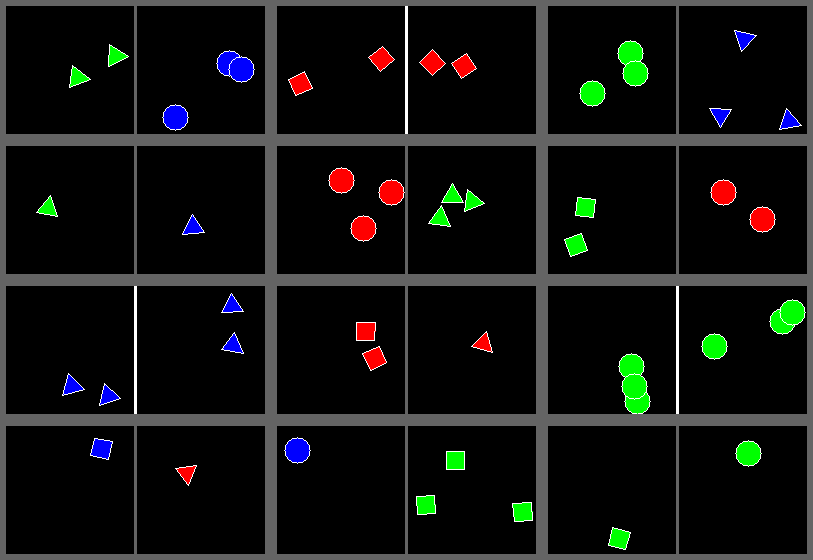

In [5]:
shapedata.demo_dataset(data)

In [6]:
from sklearn.metrics import accuracy_score as acc

NUM_EPOCHS = 2000

losses, accs = [], []
for epoch in range(NUM_EPOCHS):
    (x1, x1_shapes), (x2, x2_shapes), y = data.create_batch()
    loss, (outa, outb, y) = train_batch(np.concatenate([x1, x2]), np.expand_dims(y,1))
    loss = loss.numpy()
    accuracy = (acc(np.round(outa), y) + acc(np.round(outb), y))/2
    print(f'BATCH {epoch} | Loss: {loss} | Acc: {accuracy}', end = '\r')
    losses.append(loss)
    accs.append(accuracy)
    
# plt.figure(figsize=(10, 5), dpi=400)
# plt.plot(losses, color='red')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()
# plt.close()

# plt.figure(figsize=(10, 5), dpi=400)
# plt.plot(accs, color='red')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.show()
# plt.close()

2022-04-30 04:44:36.262448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-30 04:44:38.790336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


```
BATCH 1999 | Loss: 0.3106675446033478 | Acc: 0.880859375
```

In [7]:
model.save_weights('weights.h5')

In [8]:
# x = np.linspace(-5, 5, 1000)
# y = np.sin(x)
# plt.plot(x, y)
# plt.title('$\sin x$')
# plt.xlabel('time')
# plt.ylabel('my iq')
# plt.show()

# x = np.linspace(-5, 5, 1000)
# y = np.sin(x)
# plt.figure(dpi=500)
# plt.plot(x, y)
# plt.title('better plot of $\sin x$')
# plt.xlabel('time')
# plt.ylabel('my iq')
# plt.show()

In [9]:
testdata = shapedata.AlecModeShapeData(batch_size=BATCH_SIZE, 
                               im_size=IMG_DIM, 
                               min_shapes=MIN_SHAPES, 
                               max_shapes=MAX_SHAPES,
                               outline = OUTLINE,
                               shape_types = SHAPE_TYPES,
                               shape_colors = COLOR_TYPES,
                               shape_scale = SHAPE_SCALE)
(x1, x1_shapes), (x2, x2_shapes), y = testdata.create_batch()

In [10]:
speecha, speechb = model.get_sequence(np.concatenate([x1, x2]))

In [11]:
model.quantizer.embeddings.numpy().reshape((10, -1)).shape

ValueError: cannot reshape array of size 192 into shape (10,newaxis)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
model.quantizer.embeddings.shape

In [ ]:
embedding

In [ ]:
quant = model.quantizer(speecha)
embeddings = model.quantizer.embeddings.numpy().reshape((10, -1))

seqs = []
for sample in tqdm(range(len(quant))):
    seqs.append(model.quantizer.get_code_indices(quant[sample]).numpy())
    # seq = []
    # for word in quant[sample]:
        # seq.append(model.quantizer.get_code_indices(word.numpy()[0]))
#         for ind, embedding in enumerate(embeddings):
#             if (embedding == word.numpy()).all(): #quant[sample,word]:
#                 seq.append(ind)
    # seqs.append(seq)
    
seqs = np.array(seqs)

In [ ]:
np.unique(seqs, axis=0)

In [ ]:
len(np.unique(seqs, axis=0))

In [ ]:
a, b = pred = model(np.concatenate([x1, x2]))
pred = (a + b)/2

print('CORRECT')

for i in range(len(x2)):
    
    if np.round(pred[i]) != np.round(y[i]):

        plt.figure(figsize=(10, 5), dpi=400)
        plt.subplot(1, 2, 1)
        plt.imshow(x1[i])
        plt.axis('off')
        plt.title(f'Pred: {pred[i]}')
        plt.subplot(1, 2, 2)
        plt.imshow(x2[i])
        plt.axis('off')
        plt.title(f'Truth: {y[i]}')
        plt.show()
        plt.close()
        
        
        
print('-'*500)
print('CORRECT')

for i in range(len(x2)):
    
    if np.round(pred[i]) == np.round(y[i]):

        plt.figure(figsize=(10, 5), dpi=400)
        plt.subplot(1, 2, 1)
        plt.imshow(x1[i])
        plt.axis('off')
        plt.title(f'Pred: {pred[i]}')
        plt.subplot(1, 2, 2)
        plt.imshow(x2[i])
        plt.axis('off')
        plt.title(f'Truth: {y[i]}')
        plt.show()
        plt.close()